# RNN--are sequence models...not limited to nlp
https://karpathy.github.io/2015/05/21/rnn-effectiveness/

https://medium.com/@thisislong/building-a-recurrent-neural-network-from-scratch-ba9b27a42856

# Recurrent Neural Network (RNN) Formulas
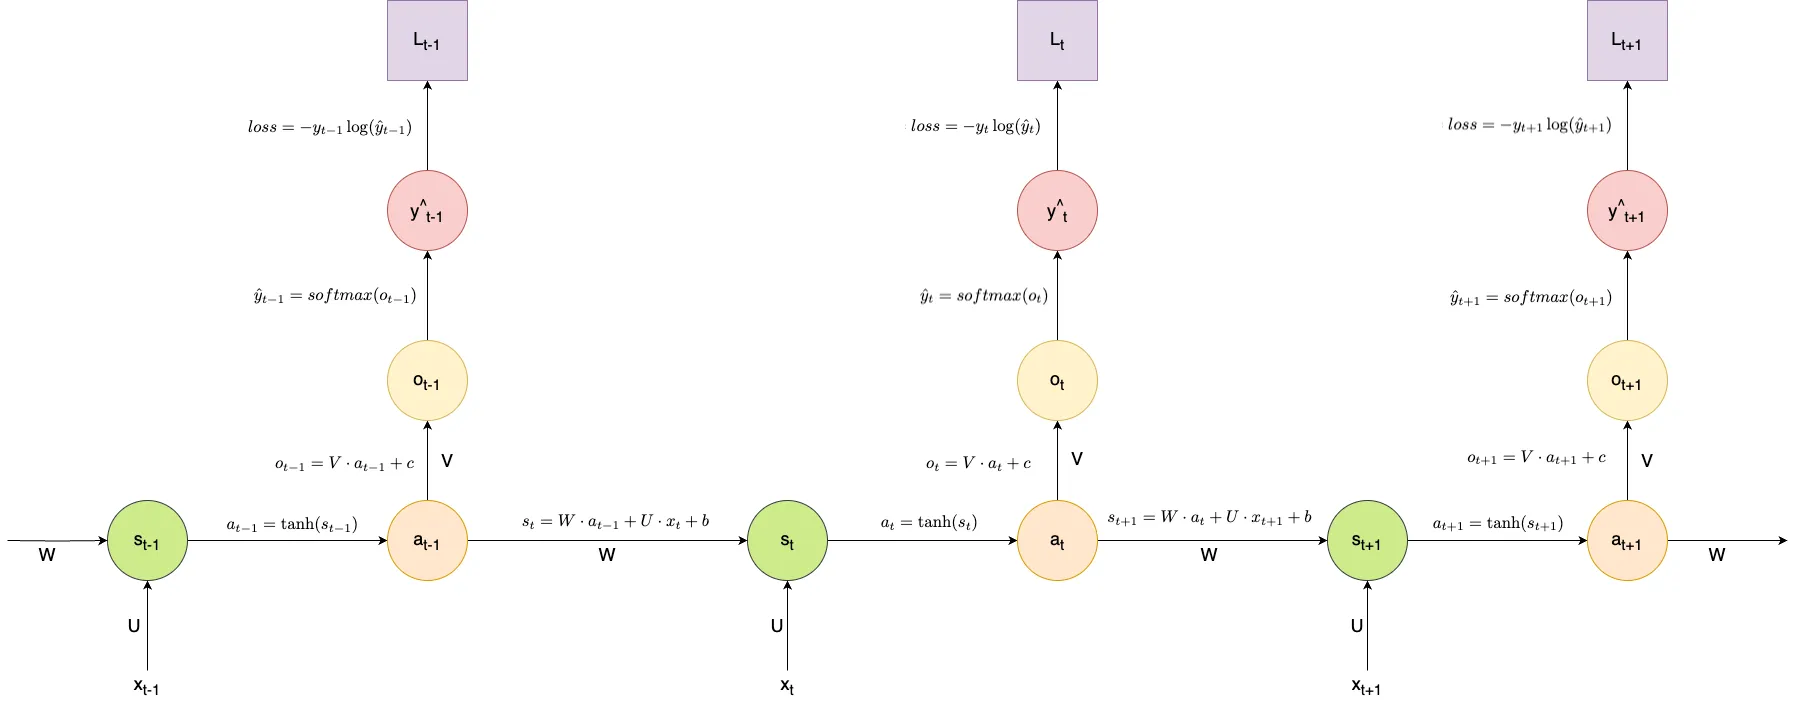

### Input Transformation
1. At each time step $t$, the input vector $x_t$ is transformed by weights:

   $$
   s_t = W \cdot a_{t-1} + U \cdot x_t + b
   $$
   where:
   - $W$ and $U$ are weight matrices for the hidden state and input.
   - $b$ is the bias term.

### Activation Function
2. The hidden state $s_t$ is passed through an activation function (e.g., $\tanh$) to obtain $a_t$:
   $$
   a_t = \tanh(s_t)
   $$

### Output Prediction
3. Output is calculated using weights $V$:
   $$
   o_t = V \cdot a_t + c
   $$
   where $c$ is the output bias.

4. Predicted output $\hat{y}_t$ is generated using the softmax activation function:
   $$
   \hat{y}_t = \text{softmax}(o_t)
   $$

### Loss Calculation
5. Cross-entropy loss is used for each time step:
   $$
   L_t = -y_t \cdot \log(\hat{y}_t)
   $$

### Backpropagation Through Time (BPTT)
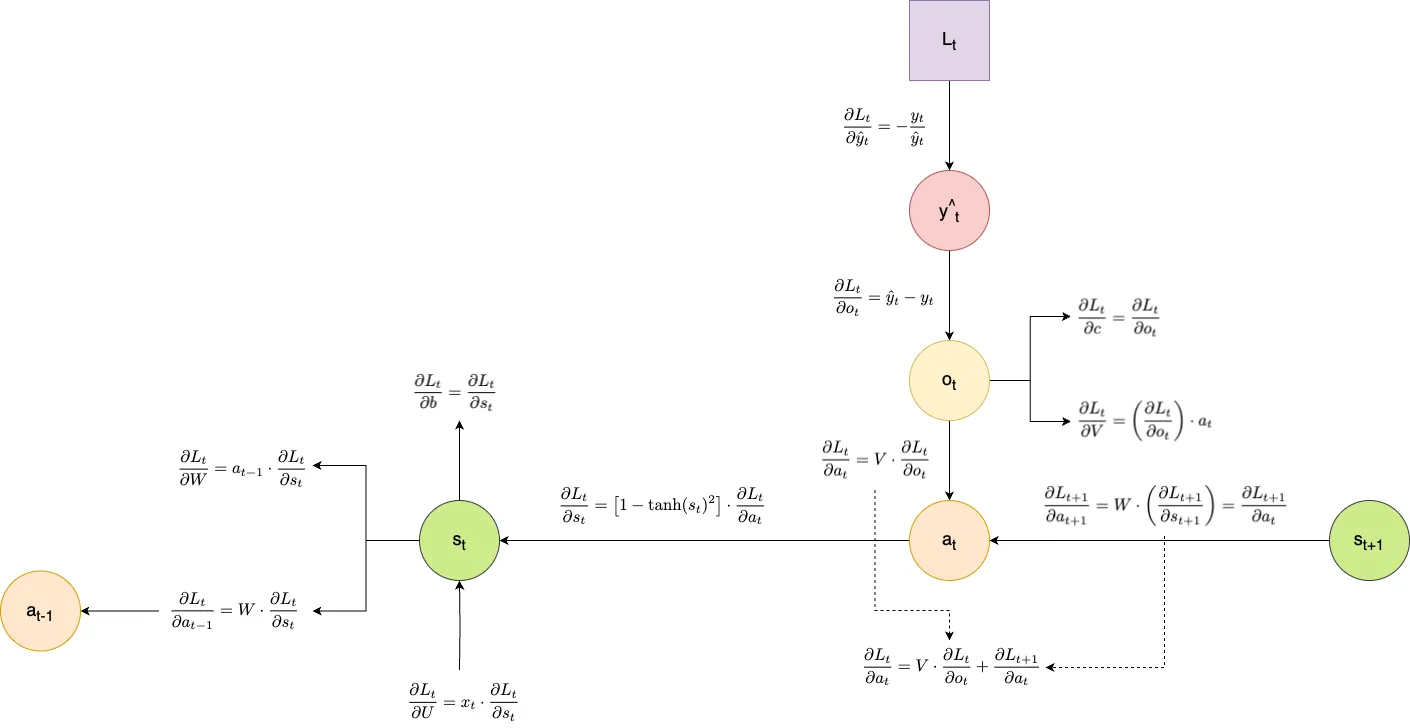
#### Gradients at Output Layer
6. Gradient of loss w.r.t. output $\hat{y}_t$:
   $$
   \frac{\partial L_t}{\partial \hat{y}_t} = \hat{y}_t - y_t
   $$

7. Gradients of weights $V$ and bias $c$:
   $$
   \frac{\partial L_t}{\partial V} = \frac{\partial L_t}{\partial o_t} \cdot a_t
   $$
   $$
   \frac{\partial L_t}{\partial c} = \frac{\partial L_t}{\partial o_t}
   $$

#### Gradients at Hidden State
8. Gradient of $L_t$ w.r.t. $a_t$:
   $$
   \frac{\partial L_t}{\partial a_t} = V \cdot \frac{\partial L_t}{\partial o_t}
   $$
Since the activation at step $t$ contributes both to the output at step $t$ and the activation of the next step $t+1$, we need to add the gradients from the current output and the next time step's loss to get the total gradient of the current activation.

The total gradient of $a_t$ is:

$$
\frac{\partial L}{\partial a_t} = \frac{\partial L_t}{\partial a_t} + W \cdot \frac{\partial L_{t+1}}{\partial a_{t+1}}
$$

This ensures dependencies across time steps are considered when updating weights in RNNs.

9. Gradient of $s_t$:
   $$
   \frac{\partial L_t}{\partial s_t} = (1 - \tanh(s_t)^2) \cdot \frac{\partial L_t}{\partial a_t}
   $$

#### Gradients of Weight Matrices $W$ and $U$
10. For $W$ and $U$:
    $$
    \frac{\partial L_t}{\partial W} = a_{t-1} \cdot \frac{\partial L_t}{\partial s_t}
    $$
    $$
    \frac{\partial L_t}{\partial U} = x_t \cdot \frac{\partial L_t}{\partial s_t}
    $$



In [6]:
import numpy as np

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of sigmoid
def sigmoid_derivative(x):
    return x * (1 - x)

# Hyperparameters
hidden_size = 3   # Hidden layer size
output_size = 1   # Output size
alpha = 0.1       # Learning rate

# Example training data (simple sentences)
data = [
    ("I love this product", 1),   # Positive
    ("This is the worst thing ever", 0),  # Negative
    ("I am so happy with this", 1),  # Positive
    ("I hate this", 0)  # Negative
]

# Create a simple vocabulary and one-hot encoding
vocabulary = ["I", "love", "this", "product", "the", "worst", "thing", "ever", "am", "so", "happy", "with", "hate"]
word_to_index = {word: i for i, word in enumerate(vocabulary)}
input_size = len(vocabulary)  # Update input size based on vocabulary

# Initialize weights
Wxh = np.random.randn(hidden_size, input_size)  # Input to hidden weights
Whh = np.random.randn(hidden_size, hidden_size) # Hidden to hidden weights
Why = np.random.randn(output_size, hidden_size) # Hidden to output weights

# Initialize biases
bh = np.zeros((hidden_size, 1))
by = np.zeros((output_size, 1))

# Function to convert sentences to one-hot encoding
def one_hot_encode(sentence):
    one_hot_vector = np.zeros((input_size, 1))
    for word in sentence.split():
        if word in word_to_index:
            one_hot_vector[word_to_index[word]] = 1
    return one_hot_vector

# Prepare training data
X = np.array([one_hot_encode(sentence) for sentence, _ in data]).reshape(-1, input_size, 1)  # Reshaping to (num_samples, input_size, 1)
Y = np.array([[label] for _, label in data])

# Forward and backward pass function
def forward_backward(X, Y, h_prev):
    global Wxh, Whh, Why, bh, by  # Declare globals at the beginning
    # Forward pass
    h = sigmoid(np.dot(Wxh, X) + np.dot(Whh, h_prev) + bh)  # Hidden state
    y_pred = sigmoid(np.dot(Why, h) + by)                   # Output prediction
    
    # Calculate loss (Mean Squared Error)
    loss = np.square(Y - y_pred) / 2
    
    # Backward pass
    dy = y_pred - Y                                         # Loss gradient w.r.t y_pred
    dWhy = np.dot(dy, h.T)                                  # Gradient w.r.t Why
    dby = dy                                                # Gradient w.r.t by
    
    dh = np.dot(Why.T, dy) * sigmoid_derivative(h)          # Gradient w.r.t h
    dWxh = np.dot(dh, X.T)                                  # Gradient w.r.t Wxh
    dWhh = np.dot(dh, h_prev.T)                             # Gradient w.r.t Whh
    dbh = dh                                                # Gradient w.r.t bh
    
    # Update weights and biases
    Wxh -= alpha * dWxh
    Whh -= alpha * dWhh
    Why -= alpha * dWhy
    bh -= alpha * dbh
    by -= alpha * dby
    
    return loss, h

# Training loop
epochs = 100
h_prev = np.zeros((hidden_size, 1))

for epoch in range(epochs):
    for x, y in zip(X, Y):  # Iterate through each training example
        loss, h_prev = forward_backward(x, y.reshape(-1, 1), h_prev)  # No need to reshape x, it should be already in correct shape
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.mean():.4f}")

# Test the model with new inputs
def predict(sentence):
    h_prev = np.zeros((hidden_size, 1))
    one_hot_vector = one_hot_encode(sentence)
    h = sigmoid(np.dot(Wxh, one_hot_vector) + np.dot(Whh, h_prev) + bh)
    y_pred = sigmoid(np.dot(Why, h) + by)
    return 1 if y_pred[0][0] > 0.5 else 0

# Example predictions
print("Predicted label for 'This is the worst thing ever':", predict("This is the worst thing ever"))


Epoch 0, Loss: 0.0209
Epoch 10, Loss: 0.0849
Epoch 20, Loss: 0.0619
Epoch 30, Loss: 0.0361
Epoch 40, Loss: 0.0211
Epoch 50, Loss: 0.0129
Epoch 60, Loss: 0.0084
Epoch 70, Loss: 0.0057
Epoch 80, Loss: 0.0041
Epoch 90, Loss: 0.0030
Predicted label for 'This product sucks with sex': 1
Predicted label for 'This is the worst thing ever': 0


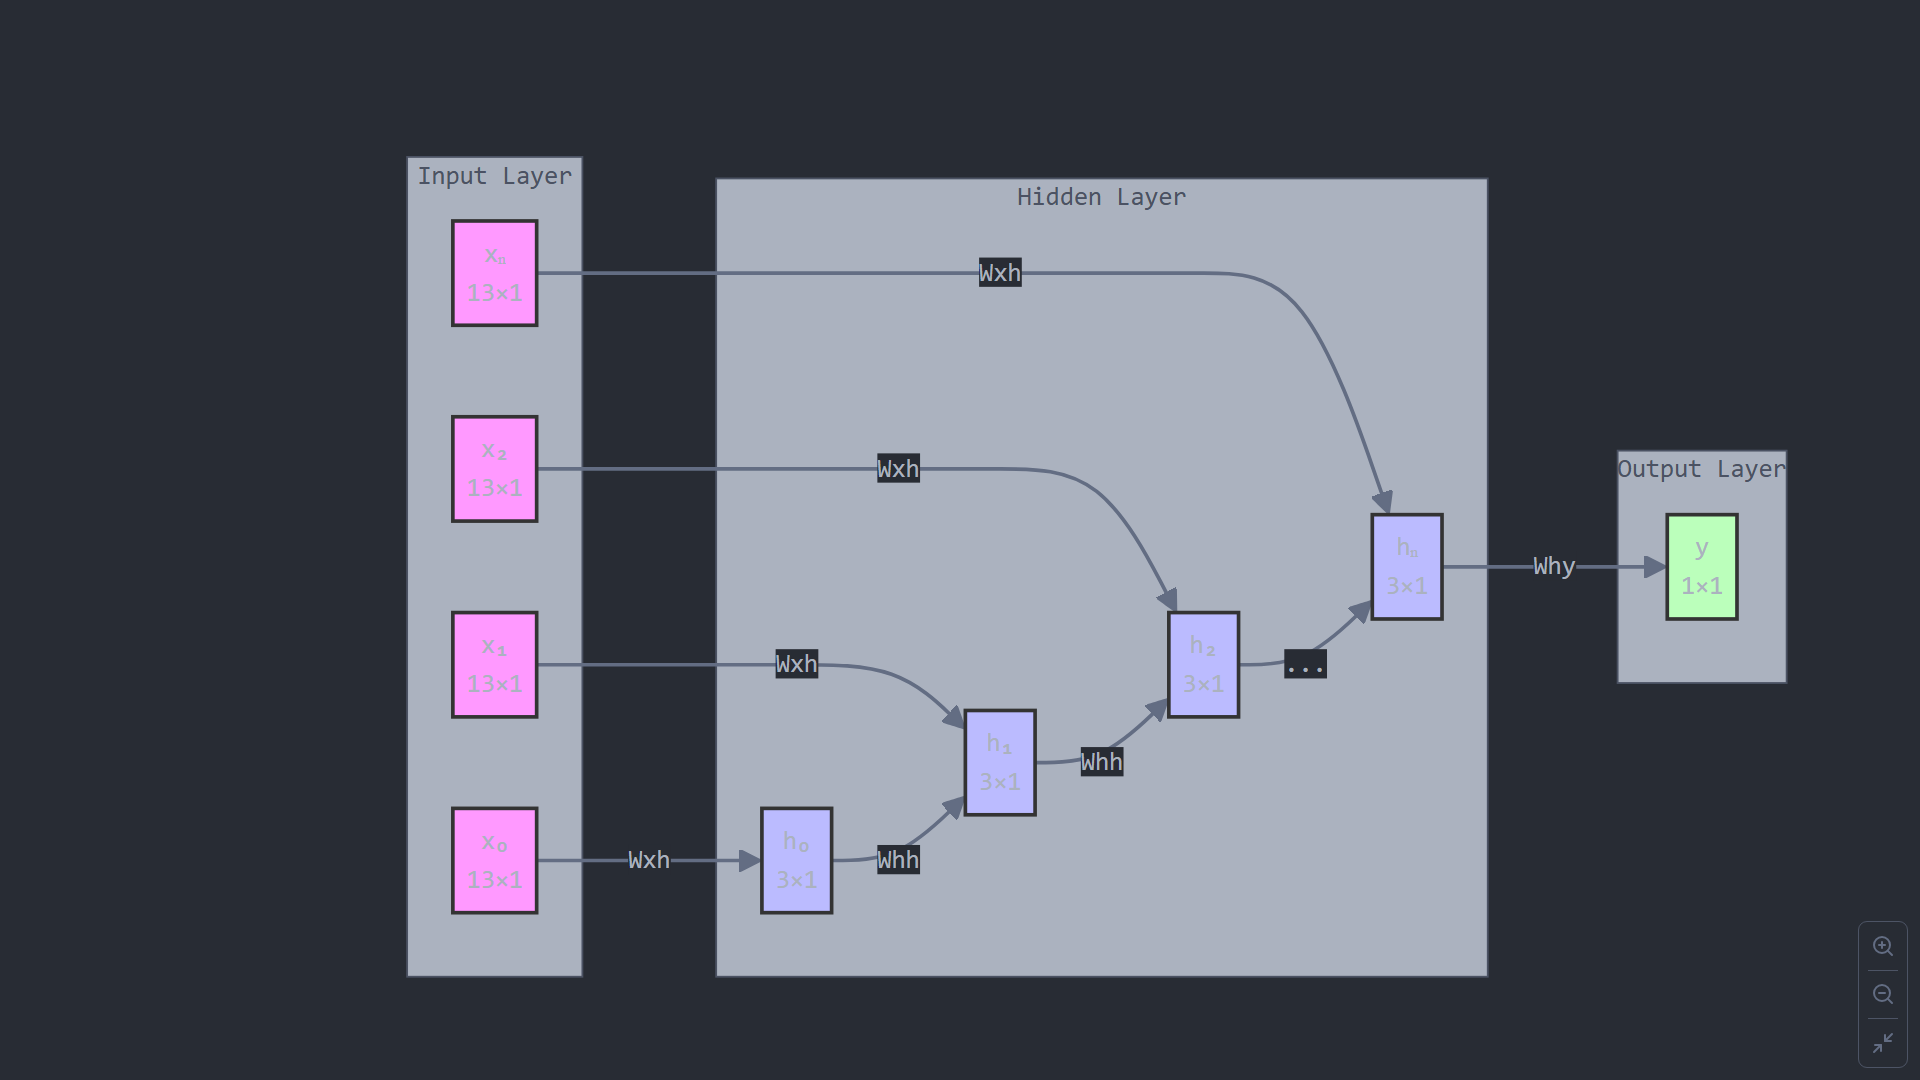

### Code Overview

The code implements a basic RNN to classify sentences as positive or negative sentiment. It involves the following main components:

1. **Activation Function**: The **sigmoid** function is used to introduce non-linearity in the network.

2. **Weight Initialization**: The network has weights connecting the input to the hidden layer (`Wxh`), hidden to hidden layer (`Whh`), and hidden to output layer (`Why`), along with biases (`bh` for hidden and `by` for output).

3. **Data Preparation**: The training data consists of sentences with corresponding labels (1 for positive, 0 for negative). The sentences are converted into one-hot encoded vectors.

4. **Forward and Backward Pass**: The `forward_backward` function performs the forward pass to compute predictions and then calculates gradients for the backward pass to update weights.

5. **Training Loop**: The model is trained over multiple epochs, iterating through each training example.

6. **Prediction Function**: A separate function to make predictions on new input sentences.

### Detailed Explanation

#### 1. **Activation Functions**

```python
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
```

- The **sigmoid function** maps any real-valued number to the range (0, 1). This is useful for modeling probabilities, which is suitable for binary classification tasks.

#### 2. **Weight Initialization**

Weights and biases are initialized randomly and set to zeros:

```python
Wxh = np.random.randn(hidden_size, input_size)  # Input to hidden weights
Whh = np.random.randn(hidden_size, hidden_size) # Hidden to hidden weights
Why = np.random.randn(output_size, hidden_size) # Hidden to output weights
bh = np.zeros((hidden_size, 1))
by = np.zeros((output_size, 1))
```

- `Wxh`: Weights connecting the input layer to the hidden layer.
- `Whh`: Weights connecting the hidden layer to itself (for maintaining the hidden state).
- `Why`: Weights connecting the hidden layer to the output layer.
- `bh` and `by`: Biases for the hidden and output layers.

#### 3. **Data Preparation**

```python
data = [
    ("I love this product", 1),   # Positive
    ("This is the worst thing ever", 0),  # Negative
    ("I am so happy with this", 1),  # Positive
    ("I hate this", 0)  # Negative
]

# Create a simple vocabulary and one-hot encoding
vocabulary = ["I", "love", "this", "product", "the", "worst", "thing", "ever", "am", "so", "happy", "with", "hate"]
word_to_index = {word: i for i, word in enumerate(vocabulary)}
input_size = len(vocabulary)  # Update input size based on vocabulary
```

- The `data` array contains sentences along with their corresponding sentiment labels.
- A vocabulary is created, and a mapping from words to indices is established for one-hot encoding.

```python
def one_hot_encode(sentence):
    one_hot_vector = np.zeros((input_size, 1))
    for word in sentence.split():
        if word in word_to_index:
            one_hot_vector[word_to_index[word]] = 1
    return one_hot_vector
```

- The `one_hot_encode` function converts each sentence into a one-hot encoded vector that represents the presence of each word in the vocabulary.

#### 4. **Forward and Backward Pass Function**

```python
def forward_backward(X, Y, h_prev):
    global Wxh, Whh, Why, bh, by  # Declare globals at the beginning
    # Forward pass
    h = sigmoid(np.dot(Wxh, X) + np.dot(Whh, h_prev) + bh)  # Hidden state
    y_pred = sigmoid(np.dot(Why, h) + by)                   # Output prediction
    
    # Calculate loss (Mean Squared Error)
    loss = np.square(Y - y_pred) / 2
    
    # Backward pass
    dy = y_pred - Y                                         # Loss gradient w.r.t y_pred
    dWhy = np.dot(dy, h.T)                                  # Gradient w.r.t Why
    dby = dy                                                # Gradient w.r.t by
    
    dh = np.dot(Why.T, dy) * sigmoid_derivative(h)          # Gradient w.r.t h
    dWxh = np.dot(dh, X.T)                                  # Gradient w.r.t Wxh
    dWhh = np.dot(dh, h_prev.T)                             # Gradient w.r.t Whh
    dbh = dh                                                # Gradient w.r.t bh
    
    # Update weights and biases
    Wxh -= alpha * dWxh
    Whh -= alpha * dWhh
    Why -= alpha * dWhy
    bh -= alpha * dbh
    by -= alpha * dby
    
    return loss, h
```

- **Forward Pass**:
  - The hidden state `h` is computed using the current input `X`, the previous hidden state `h_prev`, and the biases.
  - The output prediction `y_pred` is calculated based on the hidden state.

- **Loss Calculation**:
  - The loss is calculated using Mean Squared Error (MSE) as the metric to evaluate the performance of the model.

- **Backward Pass**:
  - Gradients of the loss with respect to predictions, weights, and biases are computed using backpropagation. The chain rule is applied to propagate gradients backward through the network.
  
- **Weight Update**:
  - The weights and biases are updated based on the calculated gradients and the learning rate `alpha`.

#### 5. **Training Loop**

```python
for epoch in range(epochs):
    for x, y in zip(X, Y):  # Iterate through each training example
        loss, h_prev = forward_backward(x, y.reshape(-1, 1), h_prev)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.mean():.4f}")
```

- The outer loop runs for a specified number of `epochs`, and the inner loop processes each training example.
- The hidden state is updated for each example, and the loss is printed every 10 epochs to monitor training progress.

#### 6. **Prediction Function**

```python
def predict(sentence):
    h_prev = np.zeros((hidden_size, 1))
    one_hot_vector = one_hot_encode(sentence)
    h = sigmoid(np.dot(Wxh, one_hot_vector) + np.dot(Whh, h_prev) + bh)
    y_pred = sigmoid(np.dot(Why, h) + by)
    return 1 if y_pred[0][0] > 0.5 else 0
```

- The `predict` function takes a sentence as input, encodes it to a one-hot vector, computes the hidden state and prediction, and returns a label based on a threshold (0.5 in this case).

### Conclusion

The provided code implements a simple RNN for sentiment classification. It involves encoding sentences into a suitable format, performing forward and backward passes to learn the weights through training, and predicting sentiment for new sentences. The key concepts illustrated include activation functions, weight initialization, forward and backward propagation, and the training loop. 


---
---
# Understanding the Vanishing Gradient Problem in RNNs

The **vanishing gradient problem** is a significant issue in training Recurrent Neural Networks (RNNs). It occurs when gradients of the loss function become too small as they are propagated backward through the network, making it difficult for the model to learn long-term dependencies.

## Why the Vanishing Gradient Problem Occurs

1. **Activation Functions**:
   - Many activation functions, like the sigmoid or tanh, squash their inputs to a small range (e.g., 0 to 1 for sigmoid). This can lead to very small gradients during backpropagation, especially when the inputs to these functions are large or small.
  
2. **Long Sequences**:
   - In RNNs, as the backpropagation goes through many time steps, the product of small gradients can lead to exponentially small gradients, effectively vanishing by the time they reach the earlier layers of the network.

3. **Weight Initialization**:
   - Poor weight initialization can exacerbate the problem, as it may lead to activation functions saturating early in training, further diminishing the gradients.

## Solutions for the Vanishing Gradient Problem

1. **Weight Initialization**:
   - Using advanced weight initialization techniques like **He initialization** helps to keep the gradients in a suitable range during the early stages of training.

2. **Echo State Networks**:
   - Echo State Networks (ESNs) are a type of RNN that maintains a reservoir of hidden states. The weights to the hidden states are fixed, which helps mitigate the vanishing gradient problem.

3. **Use of LSTM/GRU Networks**:
   - Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) networks are specifically designed to handle long-term dependencies by incorporating gates that control the flow of information, effectively reducing the impact of vanishing gradients.

## Solutions for the Exploding Gradient Problem

While the vanishing gradient problem is significant, RNNs also face the **exploding gradient problem**, where gradients grow exponentially during backpropagation, leading to unstable updates.

### Common Solutions

1. **Truncated Backpropagation**:
   - Limit the backpropagation to a fixed number of time steps, which can prevent the gradients from exploding due to a very long sequence.

2. **Selective Weight Updates**:
   - Instead of updating all the weights, selectively update certain weights to avoid drastic changes during training.

3. **Gradient Clipping**:
   - Implement gradient clipping techniques that cap the gradients at a certain threshold, preventing them from exceeding a specified value.

## Conclusion

The vanishing gradient problem is a common challenge in training RNNs, making it difficult for the model to learn long-term dependencies. Employing solutions such as weight initialization, LSTM/GRU architectures, and techniques for mitigating the exploding gradient problem can significantly improve training effectiveness.


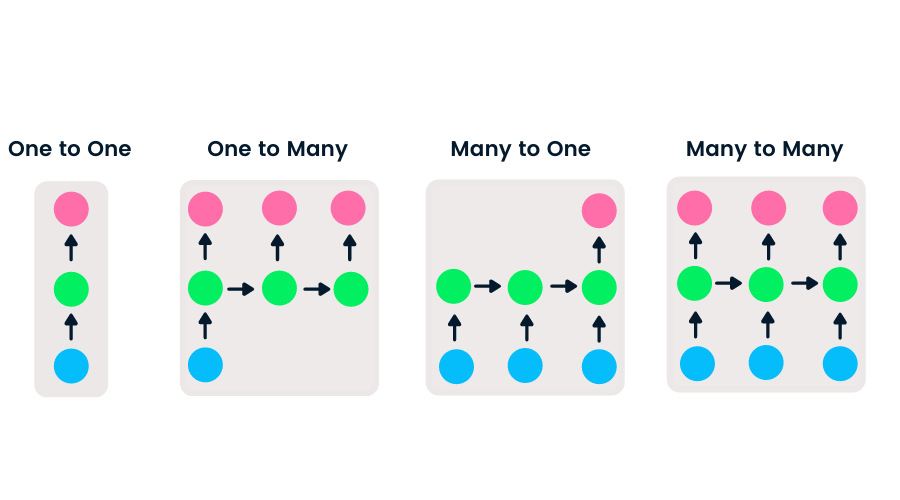

In [29]:
import numpy as np

class StoryGeneratorRNN:
    def __init__(self, vocab_size, hidden_size=128, sequence_length=50):
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        
        # Initialize weights with Xavier/Glorot initialization
        self.Wxh = np.random.randn(hidden_size, vocab_size) * np.sqrt(2.0 / (vocab_size + hidden_size))
        self.Whh = np.random.randn(hidden_size, hidden_size) * np.sqrt(2.0 / (hidden_size + hidden_size))
        self.Why = np.random.randn(vocab_size, hidden_size) * np.sqrt(2.0 / (hidden_size + vocab_size))
        
        # Initialize biases
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((vocab_size, 1))
        
        # Initialize memory for RMSprop
        self.mWxh, self.mWhh, self.mWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        self.mbh, self.mby = np.zeros_like(self.bh), np.zeros_like(self.by)
    
    def forward(self, inputs, h_prev):
        """
        Forward pass through the RNN.
        inputs: list of integers (character indices)
        h_prev: initial hidden state
        """
        x, h, y, p = {}, {}, {}, {}
        h[-1] = np.copy(h_prev)
        
        # Forward pass
        for t in range(len(inputs)):
            # One-hot encode input
            x[t] = np.zeros((self.vocab_size, 1))
            x[t][inputs[t]] = 1
            
            # Hidden state
            h[t] = np.tanh(np.dot(self.Wxh, x[t]) + np.dot(self.Whh, h[t-1]) + self.bh)
            
            # Output probabilities
            y[t] = np.dot(self.Why, h[t]) + self.by
            p[t] = np.exp(y[t]) / np.sum(np.exp(y[t]))
        
        return p, h, x
    
    def backward(self, p, h, x, targets, dh_next):
        """
        Backward pass through the RNN.
        """
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        
        for t in reversed(range(len(targets))):
            # Gradient of output probabilities
            dy = np.copy(p[t])
            dy[targets[t]] -= 1
            
            # Gradient of Why and by
            dWhy += np.dot(dy, h[t].T)
            dby += dy
            
            # Gradient of hidden state
            dh = np.dot(self.Why.T, dy) + dh_next
            
            # Backprop through tanh
            dh_raw = (1 - h[t] * h[t]) * dh
            
            # Gradient of Wxh, Whh, and bh
            dbh += dh_raw
            dWxh += np.dot(dh_raw, x[t].T)
            dWhh += np.dot(dh_raw, h[t-1].T)
            
            # Gradient for next iteration
            dh_next = np.dot(self.Whh.T, dh_raw)
        
        # Clip gradients to prevent exploding gradients
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam)
            
        return dWxh, dWhh, dWhy, dbh, dby
    
    def sample(self, h, seed_ix, n):
        """
        Sample a sequence of n characters from the model.
        h: memory state
        seed_ix: seed character index
        n: number of characters to sample
        """
        x = np.zeros((self.vocab_size, 1))
        x[seed_ix] = 1
        generated = []
        
        for _ in range(n):
            h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            y = np.dot(self.Why, h) + self.by
            p = np.exp(y) / np.sum(np.exp(y))
            
            # Sample from probability distribution
            ix = np.random.choice(range(self.vocab_size), p=p.ravel())
            x = np.zeros((self.vocab_size, 1))
            x[ix] = 1
            generated.append(ix)
            
        return generated
    
    def train(self, data, genres, learning_rate=0.001, n_epochs=100):
        """
        Train the RNN on story data with associated genres.
        data: list of (story_text, genre) tuples
        genres: list of unique genres
        """
        # Create genre embeddings
        n_genres = len(genres)
        genre_to_ix = {genre: i for i, genre in enumerate(genres)}
        genre_embeddings = np.random.randn(n_genres, self.hidden_size) * 0.01
        
        n = 0
        smooth_loss = -np.log(1.0 / self.vocab_size) * self.sequence_length
        
        for epoch in range(n_epochs):
            for story, genre in data:
                # Convert story to character indices
                chars = list(story)
                genre_ix = genre_to_ix[genre]
                
                # Initialize hidden state with genre embedding
                h = np.tanh(genre_embeddings[genre_ix].reshape(-1, 1))
                
                # Process story in sequences
                for j in range(0, len(chars) - self.sequence_length, self.sequence_length):
                    inputs = [char_to_ix[c] for c in chars[j:j + self.sequence_length]]
                    targets = [char_to_ix[c] for c in chars[j + 1:j + self.sequence_length + 1]]
                    
                    # Forward pass
                    p, h_states, x_states = self.forward(inputs, h)
                    
                    # Calculate loss
                    loss = sum(-np.log(p[t][targets[t]] + 1e-8) for t in range(len(targets)))
                    smooth_loss = smooth_loss * 0.999 + loss * 0.001
                    
                    # Backward pass
                    dWxh, dWhh, dWhy, dbh, dby = self.backward(p, h_states, x_states, targets, 
                                                              np.zeros((self.hidden_size, 1)))
                    
                    # Update with RMSprop
                    for param, dparam, mem in zip([self.Wxh, self.Whh, self.Why, self.bh, self.by],
                                                [dWxh, dWhh, dWhy, dbh, dby],
                                                [self.mWxh, self.mWhh, self.mWhy, self.mbh, self.mby]):
                        mem += dparam * dparam
                        param += -learning_rate * dparam / np.sqrt(mem + 1e-8)
                    
                    # Print progress
                    if n % 100 == 0:
                        print(f'Epoch {epoch}, Loss: {smooth_loss.item():.4f}')  # Use .item() to get the scalar
                        
                        # Generate sample text
                        sample_ix = self.sample(h, inputs[0], 200)
                        sample_text = ''.join([ix_to_char[ix] for ix in sample_ix])
                        print(f'\nSample text ({genre}):\n{sample_text}\n')
                    
                    n += 1

def prepare_data(stories):
    """
    Prepare story data for training.
    stories: list of (text, genre) tuples
    """
    # Create vocabulary from all stories
    chars = set(''.join([text for text, _ in stories]))
    vocab_size = len(chars)
    char_to_ix = {ch: i for i, ch in enumerate(sorted(chars))}
    ix_to_char = {i: ch for ch, i in char_to_ix.items()}
    
    # Get unique genres
    genres = sorted(set([genre for _, genre in stories]))
    
    return char_to_ix, ix_to_char, vocab_size, genres

# Example usage
if __name__ == "__main__":
    # Sample story data with genres
    stories = [
        ("Once upon a time in a magical forest, there lived a wise old owl who could talk. Every night, animals from all around would gather under the great oak tree to listen to his tales of adventure and wisdom. One day, a curious young rabbit named Hazel approached the owl, asking him to share the greatest secret of the forest.", "fantasy"),
        
        ("In the year 2147, humanity had finally achieved interstellar travel. A spaceship named Horizon was tasked with exploring the far reaches of the galaxy. Captain Elara Thompson stood on the bridge, looking out at the swirling colors of a distant nebula. She felt a sense of wonder and fear, knowing that new worlds awaited them, filled with unknown dangers and mysteries.", "sci-fi"),
        
        ("Detective Sarah Blake arrived at the crime scene, a dimly lit alley in the heart of the city. The body was discovered by a passerby, lying motionless against the wall. As she examined the area, she noticed a strange symbol etched into the pavement. This case was unlike any she had seen before, and she knew that every detail mattered if she was to solve the mystery.", "mystery"),
        
        ("The ancient kingdom of Eldoria was once a land of prosperity, but darkness loomed as a terrible dragon awakened from its slumber. The villagers whispered tales of bravery and sacrifice as a young knight named Aric prepared for battle. Armed with his sword and shield, he knew he must face the beast to save his homeland.", "fantasy"),
        
        ("On a distant planet called Xylon, the inhabitants communicated through light and sound. Their technology was advanced, powered by the energy of their sun. When a space probe from Earth arrived, it triggered a series of events that would change both worlds forever, leading to an unexpected alliance.", "sci-fi"),
        
        ("The clock struck midnight as Sarah opened the old, creaky door to the abandoned mansion. She had heard the rumors about it being haunted, but her curiosity pushed her forward. The air was thick with dust, and shadows danced on the walls as she moved cautiously, determined to uncover the truth behind the legends.", "mystery"),
        
        ("In the enchanted valley of Sunridge, every flower had a story to tell. One day, a young girl named Elara discovered a hidden path leading to a secret garden. As she wandered through, she stumbled upon a magical flower that granted wishes, forever changing her destiny.", "fantasy"),
        
        ("The year was 3020, and Earth was a mere memory. Humanity had colonized Mars, but not without struggles. As Commander Jenna surveyed the red landscape, she contemplated the sacrifices made for survival. Her team was on a mission to find water, essential for life on their new home.", "sci-fi"),
        
        ("The city was in chaos after the bank heist, and Detective Mark Reynolds was on the case. He pieced together clues left at the scene, a puzzle that led him into the depths of the criminal underworld. Each encounter brought him closer to the truth, but also deeper into danger.", "mystery"),
    ]

    
    # Prepare data
    char_to_ix, ix_to_char, vocab_size, genres = prepare_data(stories)
    
    # Create and train model
    rnn = StoryGeneratorRNN(vocab_size=vocab_size, hidden_size=128, sequence_length=50)
    rnn.train(stories, genres, learning_rate=0.001, n_epochs=50)
    
    # Generate new stories for each genre
    h = np.zeros((rnn.hidden_size, 1))
    for genre in genres:
        print(f"\nGenerating {genre} story:")
        seed_text = "The "
        seed_ix = char_to_ix[seed_text[0]]
        story_ix = rnn.sample(h, seed_ix, 500)
        story = ''.join([ix_to_char[ix] for ix in story_ix])
        print(story)

Epoch 0, Loss: 193.5628

Sample text (fantasy):
aa WIzW4renvDkf2wf.h1xB7glurSE3iB 7RBH4E.ilsnmkS7WRDfMfsmpz40xed.Xlcrszxyv4 iksv7BH4vsg0MpOnumgoxzctaRSX.,drel0v1cag072bBfT,Mp pWnynonBWodmevhmvz0rfymXfAwXxDvrdgMo2CwSfO3oMt0IiuawbOgXrkH2gn3atdmf4XsMi

Epoch 1, Loss: 190.7231

Sample text (mystery):
kpiidoeawa oewph ennfz  ttudnh.lhpSsad aa ieseRteldeh  daeehRhad rsoeeiavbzawtanhesr elmnucndd aaaa Retn rmiochle otleg t bspf Ssst  e a  c nSgRrhhn Jolo sddaldatdnr ya  wa c 3Jpro oaio  laaMaDs u1e.e

Epoch 3, Loss: 187.0986

Sample text (sci-fi):
anfMhao eaeXenkdeeoeenpehcidfm owe ibkyaifeereinrgidio ttt srnadgznpnl e tlceudm tm aenT gdpua,oadrotde  r  wta eooiacdemhcklM owtc e otiTee okta  veeerf a m  t  htswo  gase  ahevfveea  ekc edu a  Crp

Epoch 5, Loss: 183.6501

Sample text (fantasy):
kfpRicegy rheecega r aollid e fftJystehlrldlellvsegeueieit ceftae.nSlasaaieadde   usaSvnit e,uoa,dah cnho rteag1rhh ,ceeEte b s ,ElluD g  piOah  n aatr efe rew aghs odsSbdiieltasrbhdheuhorofh ss t rsg

E

In [23]:
# Many to Many
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
    return exp_x / exp_x.sum()

class SimpleRNN:
    def __init__(self, vocab_size, hidden_size):
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        
        # Initialize weights
        self.Wxh = np.random.randn(hidden_size, vocab_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(vocab_size, hidden_size) * 0.01
        
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((vocab_size, 1))
    
    def forward(self, inputs, h_prev):
        """
        inputs: list of one-hot vectors (vocab_size, 1)
        h_prev: initial hidden state (hidden_size, 1)
        """
        h_states = {}
        h_states[-1] = np.copy(h_prev)
        outputs = []
        
        # Forward pass through time
        for t in range(len(inputs)):
            # Convert input to column vector if necessary
            x = inputs[t].reshape(-1, 1)
            
            # Calculate hidden state
            h_states[t] = sigmoid(
                np.dot(self.Wxh, x) + 
                np.dot(self.Whh, h_states[t-1]) + 
                self.bh
            )
            
            # Calculate output
            y = np.dot(self.Why, h_states[t]) + self.by
            outputs.append(softmax(y.reshape(-1)))
        
        return np.array(outputs), h_states
    
    def backward(self, inputs, targets, h_states, outputs):
        """
        inputs: list of one-hot vectors
        targets: list of one-hot vectors
        h_states: dictionary of hidden states
        outputs: list of softmax outputs
        """
        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dWhy = np.zeros_like(self.Why)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)
        dh_next = np.zeros((self.hidden_size, 1))
        
        # Ensure we only backpropagate through the shorter sequence length
        seq_length = min(len(outputs), len(targets))
        
        for t in reversed(range(seq_length)):
            # Gradient of output
            dy = outputs[t].copy()
            dy[np.argmax(targets[t])] -= 1  # Cross-entropy derivative
            dy = dy.reshape(-1, 1)
            
            # Hidden to output weights
            dWhy += np.dot(dy, h_states[t].T)
            dby += dy
            
            # Hidden state
            dh = np.dot(self.Why.T, dy) + dh_next
            dh_raw = dh * (h_states[t] * (1 - h_states[t]))  # sigmoid derivative
            
            # Input to hidden weights
            dWxh += np.dot(dh_raw, inputs[t].reshape(1, -1))
            # Hidden to hidden weights
            dWhh += np.dot(dh_raw, h_states[t-1].T)
            dbh += dh_raw
            
            dh_next = np.dot(self.Whh.T, dh_raw)
        
        # Clip gradients
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam)
            
        return dWxh, dWhh, dWhy, dbh, dby

    def train(self, input_sentences, target_sentences, num_epochs=100, learning_rate=0.1):
        for epoch in range(num_epochs):
            total_loss = 0
            
            for input_sentence, target_sentence in zip(input_sentences, target_sentences):
                # One-hot encode input and target
                inputs = [np.eye(self.vocab_size)[char_to_ix[c]] for c in input_sentence]
                targets = [np.eye(self.vocab_size)[char_to_ix[c]] for c in target_sentence]
                
                # Forward pass
                h_prev = np.zeros((self.hidden_size, 1))
                outputs, h_states = self.forward(inputs, h_prev)
                
                # Compute loss only for the length of the shorter sequence
                seq_length = min(len(outputs), len(targets))
                loss = 0
                for t in range(seq_length):
                    loss += -np.log(outputs[t][np.argmax(targets[t])] + 1e-8)
                total_loss += loss
                
                # Backward pass
                dWxh, dWhh, dWhy, dbh, dby = self.backward(inputs[:seq_length], 
                                                          targets[:seq_length], 
                                                          h_states, 
                                                          outputs[:seq_length])
                
                # Update weights
                self.Wxh -= learning_rate * dWxh
                self.Whh -= learning_rate * dWhh
                self.Why -= learning_rate * dWhy
                self.bh -= learning_rate * dbh
                self.by -= learning_rate * dby
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {total_loss:.4f}')

def prepare_data(data):
    # Create vocabulary from all unique characters
    vocab = set(''.join([pair[0] + pair[1] for pair in data]))
    vocab_size = len(vocab)
    char_to_ix = {ch: i for i, ch in enumerate(sorted(vocab))}
    ix_to_char = {i: ch for ch, i in char_to_ix.items()}
    return vocab, vocab_size, char_to_ix, ix_to_char

def translate(rnn, sentence, char_to_ix, ix_to_char):
    inputs = [np.eye(rnn.vocab_size)[char_to_ix[c]] for c in sentence]
    h_prev = np.zeros((rnn.hidden_size, 1))
    outputs, _ = rnn.forward(inputs, h_prev)
    return ''.join([ix_to_char[np.argmax(output)] for output in outputs])

# Example usage
if __name__ == "__main__":
    # Sample data
    data = [
        ('hello', 'hola'),
        ('goodbye', 'adios'),
        ('please', 'porfavor'),
        ('thankyou', 'gracias')
    ]
    
    # Prepare data
    vocab, vocab_size, char_to_ix, ix_to_char = prepare_data(data)
    input_sentences = [pair[0] for pair in data]
    target_sentences = [pair[1] for pair in data]
    
    # Create and train model
    hidden_size = 100
    rnn = SimpleRNN(vocab_size, hidden_size)
    rnn.train(input_sentences, target_sentences, num_epochs=100)
    
    # Test translations
    for sentence in ['hello', 'goodbye', 'please']:
        translation = translate(rnn, sentence, char_to_ix, ix_to_char)
        print(f'{sentence} -> {translation}')

Epoch 0, Loss: 71.9993
Epoch 10, Loss: 62.3854
Epoch 20, Loss: 56.2481
Epoch 30, Loss: 51.1198
Epoch 40, Loss: 47.7410
Epoch 50, Loss: 45.0535
Epoch 60, Loss: 42.3419
Epoch 70, Loss: 39.0937
Epoch 80, Loss: 34.8817
Epoch 90, Loss: 29.4456
hello -> poias
goodbye -> adiosar
please -> goraar


---
---
---

Here’s a list of some of the most famous NLP models along with their development years and purposes:

# NLP Models Overview

1. RNN (1986) - Developed for processing sequential data.

2. LSTM (1997) - Developed to address the vanishing gradient problem in RNNs.

3. GRU (2014) - Developed for efficient training while capturing dependencies in sequences.

4. CNNs for NLP (2014) - Adapted for capturing local patterns in text.

5. Transformers (2017) - Developed to handle long-range dependencies without recurrence.

6. BERT (2018) - Developed for bidirectional context representation in NLP tasks.

7. GPT (2018) - Developed for generating coherent and contextually relevant text.

8. T5 (2020) - Developed for text-to-text transfer tasks across various NLP applications.

9. RoBERTa (2019) - Developed as an optimized version of BERT for improved performance.

10. XLNet (2019) - Developed to capture bidirectional context while addressing limitations of BERT.

11. CLIP (2021) - Developed for understanding images and text together.

12. Claude (2023) - Developed to enhance conversational AI with a focus on context and relevance.

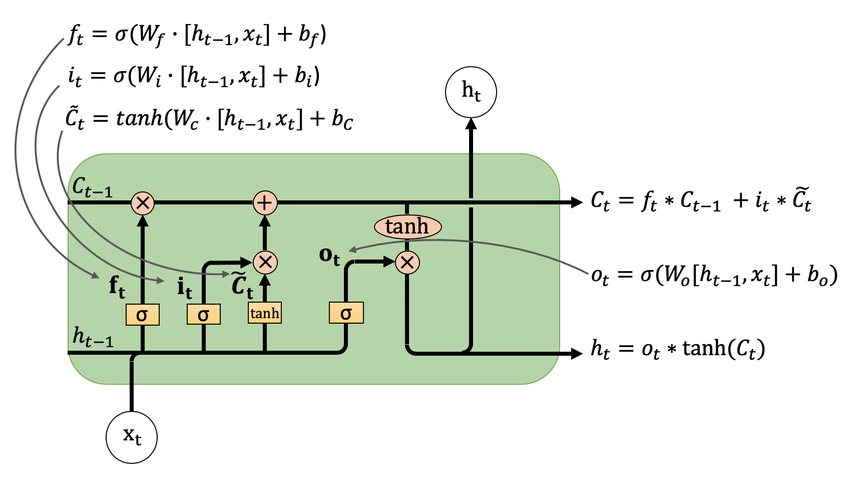